# Relationship between Critical Temperature and other features
- It follows an evaluation of the best results, looking at:
    - the *coefficients* of the Linear Regression model
    - the *feature importance* based on *mean decrease in impurity*, of Random Forest and XGBoost models
    - the *feature importance* based on *feature permutation*, of Random Forest and XGBoost models
- These measures do not necessarily imply a causal relationship. They only capture the patterns learned by the model from the data.

#### Coefficients of Linear Regression model
- In a Linear Regression model, each feature in the dataset is associated with a coefficient. Each coefficient tells how much the target variable is expected to increase when that feature increases by one unit, while holding other features constant. 
- Therefore, the sign of the coefficient (positive or negative) gives us the direction of the relationship between the feature and the target

#### Feature Importance based on Mean Decrease in Impurity
- In tree-based models, it is the total reduction of the criterion (impurity) brought by a feature. A higher value means that splitting the data using this feature reduces the impurity more than splitting it using other features, which implies this feature is more important for predicting the target variable
- It doesn't tell about the direction of the relationship between the feature and the target variable

#### Feature Importance based on Feature Permutation
- In tree-based models, it works by randomly shuffling one feature in the test data (thus preserving the distribution of the feature) and determining how much the performance of the model decreases. The idea is that the importance of a feature is proportional to how much the score (accuracy, F1, R2, etc.) decreases when the feature is not available
- It doesn't tell about the direction of the relationship between the feature and the target variable

In [7]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from utils.Combinations import Combination
from utils.Search import grid_search

from utils.Custom_Steps import HighCorrFeaturesRemover
from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

In [8]:
plt.style.use("seaborn-v0_8")

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "outputs/"

RANDOM_STATE = 42

---
---
## Data Load
(same as in training phase)

In [9]:
df = pd.concat(
    [
        pd.read_csv(DATA_FOLDER + "formula_train.csv").drop(columns=["critical_temp"]),
        pd.read_csv(DATA_FOLDER + "train.csv"),
    ],
    axis=1,
)

# Remove "material" feature (as explained in '0_DataExploration.ipynb')
df = df.drop(columns="material")

print("Shapes of Properties+Formula df: ", df.shape)

Shapes of Properties+Formula df:  (17010, 168)


---
---
## Split
(same as in training phase)

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

X_train = train.drop(columns=["critical_temp"])
y_train = train[["critical_temp"]]

X_test = test.drop(columns=["critical_temp"])
y_test = test[["critical_temp"]]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13608, 167), (3402, 167), (13608, 1), (3402, 1))

---
---
## Linear Regression
- Testing the best configuration

In [11]:
estimator_tag = "linear_regression"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "minmax + linear_regression",
            Pipeline([("minmax", preprocessing.MinMaxScaler()), ("linear_regression", LinearRegression())]),
            {},
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

# Take the coefficients of the model
coefs_lr = [
    (feature, coef) for feature, coef in zip(model.named_steps["minmax"].get_feature_names_out(), model[-1].coef_)
]
coefs_lr.sort(key=lambda x: x[1], reverse=True)


Combination 1/1  |  minmax + linear_regression
  ==> R2: 0.7538253028800118	MSE: 280.10712800561987


---
## Random Forest
- Testing the best configuration

In [12]:
estimator_tag = "random_forest"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "high_corr_features_remover + lmax + minmax + random_forest",
            Pipeline(
                [
                    ("high_corr_features_remover", HighCorrFeaturesRemover()),
                    ("lmax", preprocessing.Normalizer(norm="max")),
                    ("minmax", preprocessing.MinMaxScaler()),
                    ("random_forest", RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "high_corr_features_remover__corr_threshold": [0.99],
                "random_forest__max_samples": [0.66],
                "random_forest__criterion": ["squared_error"],
                "random_forest__n_estimators": [200],
                "random_forest__max_depth": [25],
                "random_forest__max_features": [0.6],
                "random_forest__ccp_alpha": [0],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

# Take the Mean Decrease in Impurity from the model
impurity_decrease_rf = [
    (feature, coef)
    for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, model[-1].feature_importances_)
]
impurity_decrease_rf.sort(key=lambda x: x[1], reverse=True)


# Calculate the feature Permutation for the model
features_permutation_rf = permutation_importance(
    model[-1],
    model[:-1].transform(X_test),
    y_test,
    n_repeats=10,
    scoring="r2",
    random_state=RANDOM_STATE,
    n_jobs=-1,
).importances_mean

features_permutation_rf = [
    (feature, coef) for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, features_permutation_rf)
]
features_permutation_rf.sort(key=lambda x: x[1], reverse=True)


Combination 1/1  |  high_corr_features_remover + lmax + minmax + random_forest
  ==> R2: 0.9278190011481937	MSE: 82.13034288857776


---
## XGBoost
- Testing the best configuration

In [13]:
estimator_tag = "xg_boost"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "xg_boost",
            Pipeline(
                [
                    ("xg_boost", XGBRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "xg_boost__n_estimators": [450],
                "xg_boost__learning_rate": [0.15],
                "xg_boost__max_depth": [6],
                "xg_boost__min_child_weight": [3],
                "xg_boost__gamma": [0.5],
                "xg_boost__subsample": [1.0],
                "xg_boost__colsample_bytree": [1.0],
                "xg_boost__reg_lambda": [1.0],
                "xg_boost__reg_alpha": [0.1],
                "xg_boost__tree_method": ["auto"],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

# Take the Mean Decrease in Impurity from the model
impurity_decrease_xgb = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, model[-1].feature_importances_)
]
impurity_decrease_xgb.sort(key=lambda x: abs(x[1]), reverse=True)

# Calculate the feature Permutation for the model
features_permutation_xgb = permutation_importance(
    model[-1],
    X_test,
    y_test,
    n_repeats=10,
    scoring="r2",
    random_state=RANDOM_STATE,
    n_jobs=-1,
).importances_mean

features_permutation_xgb = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, features_permutation_xgb)
]
features_permutation_xgb.sort(key=lambda x: x[1], reverse=True)


Combination 1/1  |  xg_boost
  ==> R2: 0.9313694294022581	MSE: 78.09052777731449


---
---
## Heatmaps
- Plotting a heatmap of the extracted parameters for each model

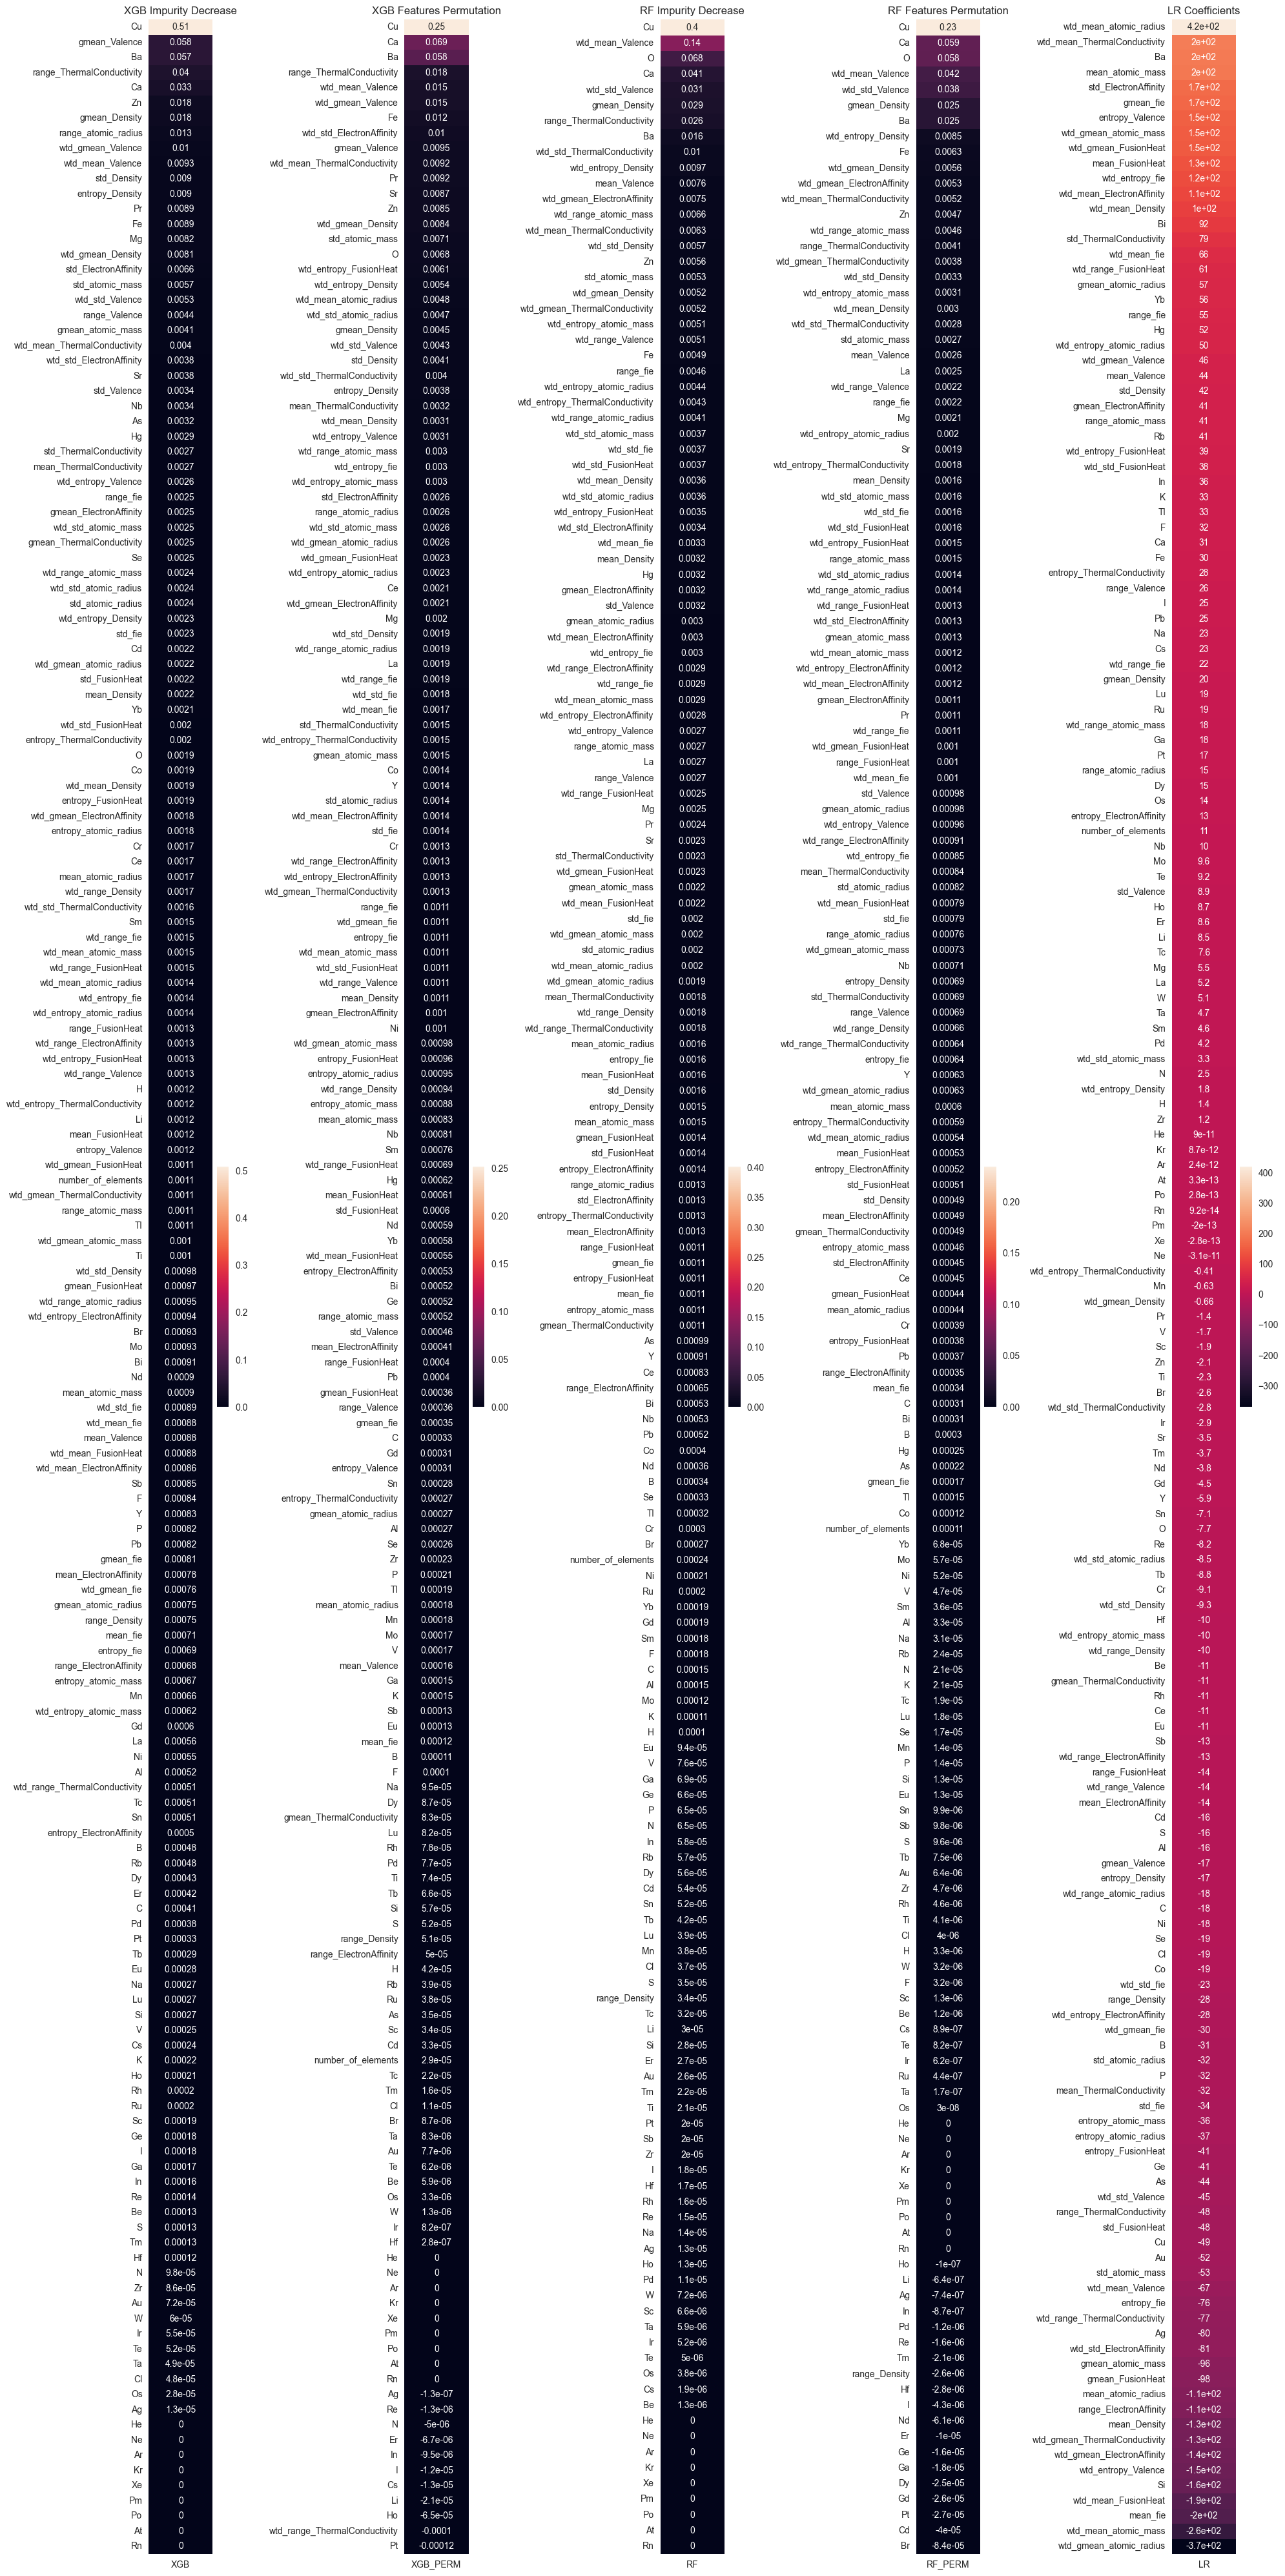

In [14]:
fig = plt.figure(figsize=(20, 40))
gs = gridspec.GridSpec(1, 5)

# Impurity Decrease of XGBoost
ax = plt.subplot(gs[0])
df = pd.DataFrame(index=[x[0] for x in impurity_decrease_xgb])
df["XGB"] = [x[1] for x in impurity_decrease_xgb]
sns.heatmap(df[["XGB"]], annot=True, ax=ax)
ax.set_title("XGB Impurity Decrease")

# Features Permutation of XGBoost
ax = plt.subplot(gs[1])
df = pd.DataFrame(index=[x[0] for x in features_permutation_xgb])
df["XGB_PERM"] = [x[1] for x in features_permutation_xgb]
sns.heatmap(df[["XGB_PERM"]], annot=True, ax=ax)
ax.set_title("XGB Features Permutation")

# Impurity Decrease of Random Forest
ax = plt.subplot(gs[2])
df = pd.DataFrame(index=[x[0] for x in impurity_decrease_rf])
df["RF"] = [x[1] for x in impurity_decrease_rf]
sns.heatmap(df[["RF"]], annot=True, ax=ax)
ax.set_title("RF Impurity Decrease")

# Features Permutation of Random Forest
ax = plt.subplot(gs[3])
df = pd.DataFrame(index=[x[0] for x in features_permutation_rf])
df["RF_PERM"] = [x[1] for x in features_permutation_rf]
sns.heatmap(df[["RF_PERM"]], annot=True, ax=ax)
ax.set_title("RF Features Permutation")

# Coefficients of Linear Regression
ax = plt.subplot(gs[4])
df = pd.DataFrame(index=[x[0] for x in coefs_lr])
df["LR"] = [x[1] for x in coefs_lr]
sns.heatmap(df[["LR"]], annot=True, ax=ax)
ax.set_title("LR Coefficients")

plt.tight_layout()
plt.show()